In [1]:
import torch
from torch import nn

在这个JupyterNotebook中，我将基于Pytorch从头开始实现一个基本的Transformer模型，最后用于中文到英文的翻译任务，在这个过程中我会重点讲解多头注意力部分，如果有不足，欢迎向我提出意见<Br>

请确保你具有基本的深度学习知识，并且掌握prtorch的基本使用

# 位置编码与嵌入


## 词嵌入

什么是词嵌入？

首先为词汇表中的每个字（或 token）分配一个唯一的整数索引（比如 "我" 对应索引 0，"你" 对应索引 1，以此类推）。

`nn.Embedding` 层内部维护一个形状为 `(vocab_size, embedding_dim)` 的权重矩阵（可学习参数），其中：
- `vocab_size`：词汇表大小（即包含的词的总数）
- `embedding_dim`：嵌入向量的维度


以句子 **“今天我很开心”** 为例：
- 其词汇表大小 `vocab_size = 6`（包含“今、天、我、很、开、心”6个token）
- 假设嵌入向量维度 `embedding_dim = 6`
- 则 `nn.Embedding` 层的权重矩阵初始状态如下（为方便展示，此处均设为0；实际训练时会初始化为随机值），矩阵中每一个维度都代表一种特征：

| token  | 维度1 | 维度2 | 维度3 | 维度4 | 维度5 | 维度6 |
| :----- | :---: | :---: | :---: | :---: | :---: | :---: |
| 0（今） |   0   |   0   |   0   |   0   |   0   |   0   |
| 1（天） |   0   |   0   |   0   |   0   |   0   |   0   |
| 2（我） |   0   |   0   |   0   |   0   |   0   |   0   |
| 3（很） |   0   |   0   |   0   |   0   |   0   |   0   |
| 4（开） |   0   |   0   |   0   |   0   |   0   |   0   |
| 5（心） |   0   |   0   |   0   |   0   |   0   |   0   |


当输入一个字的索引 `i` 时，`nn.Embedding` 层会直接从上述权重矩阵中取出第 `i` 行的向量，作为该字的嵌入向量。


随着训练的进行，**具有相似语义的词会在高维空间中的距离越来越近**。例如“菠萝”和“香蕉”（同为水果）：
1. 初始时刻：若映射到二维空间，“苹果”的嵌入向量可能为 `(-2,-1)`，“菠萝”的嵌入向量可能为 `(1,3)`，二者距离较远；
2. 训练后：“苹果”的向量可能变为 `(2,4)`，“菠萝”的向量可能变为 `(3,3)`，二者距离显著缩短。

在**正常训练（数据充分、任务合理）** 的情况下，词嵌入模型会通过学习语境规律，让语义相似的词在高维空间中逐渐靠近。

In [2]:
# 假设我们批次大小为2，序列长度为6,形状(batch_size,seq_len)
input_tensor = torch.randint(0, 4, size=(2, 6))
# 假设我们这里6个字互不相同
vocab_size = 6
embedding_dim = 10 # 嵌入向量的维度
embed = nn.Embedding(vocab_size, embedding_dim=embedding_dim)
# 嵌入输入向量应该为整数，因为每一个索引对应一个词，索引不能为小数
input_tensor_embedded = embed(input_tensor)
input_tensor_embedded.shape

torch.Size([2, 6, 10])

## 位置编码

- `torch.log` 是以自然常数 `e` 为底数。
- `2i` 表示位置编码向量的**偶数维度索引**。


### 1. 原论文中的正余弦编码公式
- **偶数维度编码（正弦函数）**：
  $$
  \text{PE}(\text{pos}, 2i) = \sin\left( \frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}} \right)
  $$
- **奇数维度编码（余弦函数）**：
  $$
  \text{PE}(\text{pos}, 2i+1) = \cos\left( \frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}} \right)
  $$

实际实现时，我采用原论文公式的变形形式进行正余弦编码，具体推导过程如下：


### 2. 公式变形推导
$$
\begin{align*}
\text{div\_term} &= \exp\left( 2i \times \left( -\frac{\log(10000)}{d_{\text{model}}} \right) \right) \\
&= \exp\left( -\frac{2i \cdot \log(10000)}{d_{\text{model}}} \right) \\
&= \exp\left( \log(10000) \times \left( -\frac{2i}{d_{\text{model}}} \right) \right) \\
&= 10000^{-\frac{2i}{d_{\text{model}}}} \quad \text{（根据对数性质：} \exp(a \cdot \log(b)) = b^a\text{）} \\
&= \frac{1}{10000^{\frac{2i}{d_{\text{model}}}}}
\end{align*}
$$
由此可知，代码中的 `position * div_term` 等价于原公式中的核心部分：
$$
\frac{\text{pos}}{10000^{\frac{2i}{d_{\text{model}}}}}
$$

最终，在 `position * div_term` 的基础上分别施加正弦、余弦函数，即可得到完整的位置编码。


### 3. 为什么不直接使用论文中的原始公式？
核心原因是**保证数值计算的稳定性**：
直接计算 `10000^(2i/d_model)` 时，若 `d_model` 较小（如维度较低的模型），指数部分 `2i/d_model` 可能过大，导致结果数值溢出；而通过 `exp` 和 `log` 的组合（利用对数性质 `a^b = exp(b·log(a))`），可以将“直接计算高次幂”转化为“指数与对数的乘积运算”，有效避免数值溢出问题，因此代码中选择变形公式而非原始公式。

In [3]:

# 获取序列长度
seq_len = input_tensor_embedded.shape[1]
# 创建位置编码(正余弦)
position = torch.arange(seq_len).unsqueeze(1)
div_term = torch.exp(
    torch.arange(0,embedding_dim, 2, device=input_tensor.device) # 这个张量中的每个元素即为上面推导过程中的 2i
    * (-torch.log(torch.tensor(10000.0, device=input_tensor.device)) / embedding_dim)
)

pos_encoding = torch.zeros(seq_len, embedding_dim, device=input_tensor.device)
pos_encoding[:, 0::2] = torch.sin(position * div_term)
pos_encoding[:, 1::2] = torch.cos(position * div_term)

## 位置编码与词嵌入类

In [4]:
class EmbeddingPositionEncode(nn.Module):
    def __init__(self, d_model, dropout: float, vocab_size):
        super().__init__()
        self.d_model = d_model
        self.dropout = nn.Dropout(dropout) # Dropout减少过拟合
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, input_tensor: torch.Tensor) -> torch.Tensor:
        # x_1:(batch_size,seq_len,d_model)
        x_1 = self.embedding(input_tensor)
        seq_len = input_tensor.shape[1]

        # 创建位置编码(正余弦)
        position = torch.arange(seq_len, device=input_tensor.device).unsqueeze(1) # unsqueeze(1)添加批次维度
        div_term = torch.exp(
            torch.arange(0, self.d_model, 2, device=input_tensor.device)
            * (
                -torch.log(torch.tensor(10000.0, device=input_tensor.device))
                / self.d_model
            )
        )

        pos_encoding = torch.zeros(seq_len, self.d_model, device=input_tensor.device)
        pos_encoding[:, 0::2] = torch.sin(position * div_term)
        pos_encoding[:, 1::2] = torch.cos(position * div_term)

        # 添加位置编码
        x_2 = pos_encoding.unsqueeze(0)
        return self.dropout(x_1 + x_2)

# 多头注意力


## 注意力

### 1. 什么是注意力？
注意力本质是“一个变量对另一个变量的关注度”。我们可以通过生活场景理解其核心逻辑：

如果你想在桌子上找一本书（而非一杯水），此时你对“书”的关注度会远高于其他物品。在注意力机制中，这个场景可拆解为三个核心概念：
- **Query（查询）**：触发注意力的“动机”，也叫“随意线索”（“随意”指跟随意志），对应“你想找一本书”这个需求。
- **Key（键）**：被关注对象的“标签”，用于与Query匹配，判断是否符合需求，对应“桌子上所有物品的特征”（如书的“蓝色封面”、水杯的“透明玻璃”）。
- **Value（值）**：被关注对象的“具体内容/信息”——当Key与Query匹配度高（关注度高）时，重点提取其Value；匹配度低则少提取或不提取，对应“书的书名、作者”“水杯的容量、水温”等具体信息。


#### Query/Key/Value 概念对应表
| 矩阵                | 含义                                                                 | 对应场景的实例                                                                 |
|---------------------|----------------------------------------------------------------------|------------------------------------------------------------------------------|
| **Query（查询）**   | 触发注意力的“动机”，也称为“随意线索”（“随意”指跟随意志）。               | 你的需求：“找一本封面是蓝色的小说”                                           |
| **Key（键）**       | 被关注对象的“标签”，用于与 Query 匹配，判断该对象是否符合 Query 的需求。 | 桌子上物品的特征：<br>- 书：蓝色封面、小说类<br>- 水杯：透明玻璃、装水<br>- 纸巾：白色包装、日用品 |
| **Value（值）**     | 被关注对象的“具体内容/信息”，按 Key 与 Query 的匹配度加权提取。         | 各物品的具体信息：<br>- 书的 Value：书名《百年孤独》、作者马尔克斯、内容摘要<br>- 水杯的 Value：容量 500ml、水温 25℃<br>- 纸巾的 Value：品牌 XX、抽数 100 张 |


### 2. 注意力计算实例（文本翻译任务）
为简化理解，设定任务参数：
- 模型维度 `d_model = 4`
- 批次大小 `batch_size = 1`

#### 核心矩阵形状定义
- Query 形状：`(batch_size, seq_len_q, d_model)`（`seq_len_q` 为查询序列长度，此处对应中文句子长度）
- Key 形状：`(batch_size, seq_len_k, d_model)`（`seq_len_k` 为键序列长度，此处对应英文句子长度）
- Value 形状：`(batch_size, seq_len_k, d_model)`（与 Key 序列长度一致）


#### 步骤1：计算注意力分数（未归一化）
注意力分数用于衡量 Query 与 Key 的语义关联程度，计算公式为：  
`scores = query @ key.transpose(-2, -1)`  

- 矩阵乘法逻辑：`(1, 5, 4) @ (1, 4, 5) = (1, 5, 5)`（最终形状为 `(batch_size, seq_len_q, seq_len_k)`）
- 数值含义：`scores[i][j]` 表示“中文第 i 个字”与“英文第 j 个词”的关联度，数值越高关联越强。

以下为“中文句子（今、天、我、很、开心）→ 英文句子（I、am、very、happy、today）”的未归一化分数矩阵：

| 中文Query（行）\ 英文Key（列） | I    | am   | very | happy | today |
|--------------------------------|------|------|------|-------|-------|
| 今                             | 0.1  | 0.1  | 0.1  | 0.1   | **0.8**|
| 天                             | 0.1  | 0.1  | 0.1  | 0.1   | **0.7**|
| 我                             | **0.9**| 0.2  | 0.1  | 0.1   | 0.1   |
| 很                             | 0.1  | 0.1  | **0.8**| 0.2   | 0.1   |
| 开心                           | 0.1  | 0.2  | 0.3  | **0.9**| 0.1   |

> 示例解读：中文“今”与英文“today”关联度最高（0.8），中文“开心”与英文“happy”关联度最高（0.9），符合语义逻辑。


#### 步骤2：Softmax 归一化（转化为“关注度概率”）
为让“关联度”转化为“可加权的概率”，对分数矩阵按行（`dim=-1`）做 Softmax 运算，确保每行数值和为 1。

归一化后的注意力分数矩阵：

| 中文Query（行）\ 英文Key（列） | I    | am   | very | happy | today | 行和（验证） |
|--------------------------------|------|------|------|-------|-------|--------------|
| 今                             | 0.18 | 0.18 | 0.18 | 0.18  | **0.28**| 1.0          |
| 天                             | 0.19 | 0.19 | 0.19 | 0.19  | **0.24**| 1.0          |
| 我                             | **0.65**| 0.09 | 0.08 | 0.08   | 0.08   | 1.0          |
| 很                             | 0.08 | 0.08 | **0.60**| 0.12   | 0.08   | 1.0          |
| 开心                           | 0.08 | 0.09 | 0.11 | **0.62**| 0.10   | 1.0          |


#### 步骤3：注意力加权（获取最终输出）
用归一化后的分数矩阵对 Value 矩阵加权求和，公式为：  
`out = scores @ value`  

- 矩阵乘法逻辑：`(1, 5, 5) @ (1, 5, 4) = (1, 5, 4)`（最终形状与 Query 一致，为 `(batch_size, seq_len_q, d_model)`）
- Value 矩阵定义：存储英文词的核心语义特征（此处设为4个维度：人称、情绪、程度、时间）。


##### 英文词的 Value 矩阵
| 英文词（Key/Value） | 维度0（人称） | 维度1（情绪） | 维度2（程度） | 维度3（时间） |
|---------------------|---------------|---------------|---------------|---------------|
| I                   | 0.9           | 0.2           | 0.1           | 0.1           |
| am                  | 0.3           | 0.3           | 0.2           | 0.1           |
| very                | 0.1           | 0.2           | 0.9           | 0.1           |
| happy               | 0.2           | 0.9           | 0.3           | 0.1           |
| today               | 0.1           | 0.1           | 0.1           | 0.9           |


##### 注意力加权结果（out 矩阵）
| 中文Query（行） | 维度0（人称）                                                                 | 维度1（情绪）                                                                 | 维度2（程度）                                                                 | 维度3（时间）                                                                 |
|-----------------|-------------------------------------------------------------------------------|-------------------------------------------------------------------------------|-------------------------------------------------------------------------------|-------------------------------------------------------------------------------|
| 今              | 0.18×0.9 + 0.18×0.3 + 0.18×0.1 + 0.18×0.2 + 0.28×0.1 = 0.28                   | 0.18×0.2 + 0.18×0.3 + 0.18×0.2 + 0.18×0.9 + 0.28×0.1 = 0.25                   | 0.18×0.1 + 0.18×0.2 + 0.18×0.9 + 0.18×0.3 + 0.28×0.1 = 0.22                   | 0.18×0.1 + 0.18×0.1 + 0.18×0.1 + 0.18×0.1 + 0.28×0.9 = 0.30                   |
| 天              | 0.19×0.9 + 0.19×0.3 + 0.19×0.1 + 0.19×0.2 + 0.24×0.1 = 0.27                   | 0.19×0.2 + 0.19×0.3 + 0.19×0.2 + 0.19×0.9 + 0.24×0.1 = 0.24                   | 0.19×0.1 + 0.19×0.2 + 0.19×0.9 + 0.19×0.3 + 0.24×0.1 = 0.21                   | 0.19×0.1 + 0.19×0.1 + 0.19×0.1 + 0.19×0.1 + 0.24×0.9 = 0.28                   |
| 我              | 0.65×0.9 + 0.09×0.3 + 0.08×0.1 + 0.08×0.2 + 0.08×0.1 = 0.62                   | 0.65×0.2 + 0.09×0.3 + 0.08×0.2 + 0.08×0.9 + 0.08×0.1 = 0.22                   | 0.65×0.1 + 0.09×0.2 + 0.08×0.9 + 0.08×0.3 + 0.08×0.1 = 0.18                   | 0.65×0.1 + 0.09×0.1 + 0.08×0.1 + 0.08×0.1 + 0.08×0.9 = 0.16                   |
| 很              | 0.08×0.9 + 0.08×0.3 + 0.60×0.1 + 0.12×0.2 + 0.08×0.1 = 0.18                   | 0.08×0.2 + 0.08×0.3 + 0.60×0.2 + 0.12×0.9 + 0.08×0.1 = 0.25                   | 0.08×0.1 + 0.08×0.2 + 0.60×0.9 + 0.12×0.3 + 0.08×0.1 = 0.59                   | 0.08×0.1 + 0.08×0.1 + 0.60×0.1 + 0.12×0.1 + 0.08×0.9 = 0.17                   |
| 开心            | 0.08×0.9 + 0.09×0.3 + 0.11×0.1 + 0.62×0.2 + 0.10×0.1 = 0.22                   | 0.08×0.2 + 0.09×0.3 + 0.11×0.2 + 0.62×0.9 + 0.10×0.1 = 0.64                   | 0.08×0.1 + 0.09×0.2 + 0.11×0.9 + 0.62×0.3 + 0.10×0.1 = 0.32                   | 0.08×0.1 + 0.09×0.1 + 0.11×0.1 + 0.62×0.1 + 0.10×0.9 = 0.18                   |


### 3. 结果
#### 结果语义
从加权输出矩阵可看出，中文每个字都精准捕捉到了英文对应词的核心特征：
- 中文“今”“天”：维度3（时间）数值最高（0.30/0.28），对应英文“today”的时间特征；
- 中文“我”：维度0（人称）数值最高（0.62），对应英文“I”的人称特征；
- 中文“很”：维度2（程度）数值最高（0.59），对应英文“very”的程度特征；
- 中文“开心”：维度1（情绪）数值最高（0.64），对应英文“happy”的情绪特征。


#### 注意力机制总结
1. **Value 存储特征**：Value 矩阵记录被关注对象（如英文词）的核心语义特征；
2. **Score 建立关联**：注意力分数矩阵（经 Softmax 归一化）找到 Query（如中文词）与 Key（如英文词）的语义关联；
3. **Weighted 定制输出**：通过分数加权 Value，为每个 Query 定制“最相关的语义特征”，后续解码器可基于此生成准确结果（如中文译文）。

## 多头注意力

相比于基础注意力（单头注意力），多头注意力的实现流程有所差异，核心是通过“多组独立特征空间”捕捉更丰富的语义关联。


### 1. 第一步：线性投影（Query/Key/Value 空间映射）
对于输入的 Query、Key、Value，首先分别与三个独立的权重矩阵进行矩阵乘法（即线性投影），公式如下：  
- $q = query \ @ \ W_q$  
- $k = key \ @ \ W_k$  
- $v = value \ @ \ W_v$  

其中，三个权重矩阵的形状均为 $(d_{model}, d_{model})$，投影后 Query、Key、Value 的维度仍保持 $d_{model}$（与输入维度一致）。


#### 为什么需要线性投影？
基础注意力（单头）的局限性在于：Query、Key、Value 共享同一个 $d_{model}$ 维特征空间，所有语义信息（如人称、情绪、程度、时间等）都混合在这一个空间中，模型只能用“同一套标准”捕捉关联——类似用“万能工具”解决所有问题，无法对不同类型的信息做针对性处理。  

而线性投影的核心作用，是为后续“拆分多特征空间”做准备：通过不同的权重矩阵 $W_q、W_k、W_v$，将原始 Query、Key、Value 映射到新的特征空间，后续再拆分为多个独立子空间，让每个子空间专注于捕捉某一类特定语义信息（例如：头1专注“人称+情绪”，头2专注“程度+时间”）。


### 2. 第二步：拆分多头（构建多独立特征空间）
线性投影后，需要将 Query、Key、Value 按“头数（heads）”拆分为多个子矩阵，具体步骤如下：

#### 关键参数定义
- 头数：$heads$（需满足 $d_{model} \% heads = 0$，确保每个头的维度均匀）  
- 每个头的维度：$head\_dim = d_{model} // heads$  


#### 矩阵形状变化
以“$d_{model}=4$，$heads=2$”（延续前文翻译任务示例）为例，拆分前后的矩阵形状变化如下：  
| 矩阵   | 线性投影后形状                | 拆分多头后形状                          |
|--------|-----------------------------|---------------------------------------|
| Query  | $(batch\_size, seq\_len_q, d_{model})$ | $(batch\_size, seq\_len_q, heads, head\_dim)$ |
| Key    | $(batch\_size, seq\_len_k, d_{model})$ | $(batch\_size, seq\_len_k, heads, head\_dim)$ |
| Value  | $(batch\_size, seq\_len_k, d_{model})$ | $(batch\_size, seq\_len_k, heads, head\_dim)$ |

代入具体数值（$batch\_size=1$，$seq\_len_q=5$，$seq\_len_k=5$）：  
- 投影后：$(1, 5, 4)$  
- 拆分后：$(1, 5, 2, 2)$（2个头，每个头维度为2）  


### 3. 第三步：调整形状与计算注意力分数
为了让每个头独立计算注意力关联，需要先调整 Query 和 Key 的维度顺序，再进行矩阵乘法计算分数：

#### 形状调整逻辑
- Query 调整：从 $(batch\_size, seq\_len_q, heads, head\_dim)$ 变为 $(batch\_size, heads, seq\_len_q, head\_dim)$  
  → 目的：将“头数（heads）”维度提前，确保每个头的计算相互独立。  
- Key 调整：从 $(batch\_size, seq\_len_k, heads, head\_dim)$ 变为 $(batch\_size, heads, head\_dim, seq\_len_k)$  
  → 目的：满足矩阵乘法维度要求（Query 的最后一维需与 Key 的倒数第二维一致）。  


#### 计算注意力分数
调整形状后，通过矩阵乘法计算每个头的注意力分数：  
$scores = q \ @ \ k$  

- 形状变化：$(batch\_size, heads, seq\_len_q, head\_dim) \ @ \ (batch\_size, heads, head\_dim, seq\_len_k) = (batch\_size, heads, seq\_len_q, seq\_len_k)$  
- 数值含义：$scores[b][h][i][j]$ 表示“第 b 个批次、第 h 个头”中，Query 的第 i 个元素与 Key 的第 j 个元素的关联度。


### 4. 因果掩码（避免未来信息泄露）
在文本翻译、文本生成等**自回归任务**中，模型需要“根据前一时刻的输出预测下一时刻结果”，因此必须确保：计算当前位置的注意力时，**不能看到后续位置的信息**（即“未来信息泄露”）。因果掩码（Causal Mask）就是解决这一问题的核心手段。


#### 1）未加掩码的问题（未来信息泄露）
以中文句子“今、天、我、很、开心”的自注意力计算为例（Query 和 Key 均为该句子），未加掩码时的注意力分数矩阵如下（行=Query 位置，列=Key 位置）：

| 中文Query（行）\ 中文Key（列） | 今          | 天          | 我          | 很          | 开心        |
|--------------------------------|-------------|-------------|-------------|-------------|-------------|
| 今                             | 今/今       | 今/天       | 今/我       | 今/很       | 今/开心     |
| 天                             | 天/今       | 天/天       | 天/我       | 天/很       | 天/开心     |
| 我                             | 我/今       | 我/天       | 我/我       | 我/很       | 我/开心     |
| 很                             | 很/今       | 很/天       | 很/我       | 很/很       | 很/开心     |
| 开心                           | 开心/今     | 开心/天     | 开心/我     | 开心/很     | 开心/开心   |

此时存在严重问题：计算“今”的注意力时，模型能看到“天、我、很、开心”等未来位置的信息，违背自回归任务的逻辑（模型本应只基于“今”之前的信息预测后续）。


#### 2）加因果掩码后的效果
因果掩码的核心操作：将“Query 位置 < Key 位置”的元素（即矩阵右上角区域）设为 $-\infty$（负无穷）。这样在后续 Softmax 归一化时，$-\infty$ 会被映射为 0，模型将不再关注这些“未来位置”的信息。

加掩码后的注意力分数矩阵如下：

| 中文Query（行）\ 中文Key（列） | 今          | 天          | 我          | 很          | 开心        |
|--------------------------------|-------------|-------------|-------------|-------------|-------------|
| 今                             | 今/今       | $-\inf$     | $-\inf$     | $-\inf$     | $-\inf$     |
| 天                             | 天/今       | 天/天       | $-\inf$     | $-\inf$     | $-\inf$     |
| 我                             | 我/今       | 我/天       | 我/我       | $-\inf$     | $-\inf$     |
| 很                             | 很/今       | 很/天       | 很/我       | 很/很       | $-\inf$     |
| 开心                           | 开心/今     | 开心/天     | 开心/我     | 开心/很     | 开心/开心   |

此时每个 Query 位置仅能关注“当前及之前”的 Key 位置，完全符合自回归任务的逻辑。

## 多头注意力类

In [5]:
class MultiHeadAttention(nn.Module):

    def __init__(
        self, d_model: int, heads: int, dropout: float = 0, mask: bool = False
    ):

        super().__init__()
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model) # 变换回 d_model

        self.d_model = d_model
        self.mask = mask

        self.heads = heads

        self.head_dim = d_model // heads
        self.dropout = nn.Dropout(dropout)

    def forward(
        self,
        query: torch.Tensor,
        key: torch.Tensor,
        value: torch.Tensor,
        key_padding_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        # (batch_size,seq_len,d_model)
        batch_size, seq_len_q = query.size(0), query.size(1)
        seq_len_k = key.size(1)
        # 线性投影,分割多头
        # (batch_size,heads,seq_len_q,head_dim)
        q = (
            self.W_q(query)
            .view(batch_size, seq_len_q, self.heads, self.head_dim)
            .transpose(1, 2)
        )
        # (batch_size,heads,seq_len_k,head_dim)
        k = (
            self.W_k(key)
            .view(batch_size, seq_len_k, self.heads, self.head_dim)
            .transpose(1, 2)
        )
        # (batch_size,heads,seq_len_k,head_dim)
        v = (
            self.W_v(value)
            .view(batch_size, seq_len_k, self.heads, self.head_dim)
            .transpose(1, 2)
        )

        # 计算注意力分数
        # scores:(batch_size,heads,seq_len_q,seq_len_k)
        scores = q @ k.transpose(-2, -1)
        # 因果掩码,防止模型看见未来的信息
        if self.mask:
            mask_matrix = torch.triu(
                torch.full((seq_len_q, seq_len_k), float("-inf")), diagonal=1
            ).to(query.device)
            scores = scores + mask_matrix
        # 掩蔽字符<pad>,因为它无意义
        if key_padding_mask is not None:
            # 确保key_padding_mask是布尔类型
            if key_padding_mask.dtype != torch.bool:
                key_padding_mask = key_padding_mask.bool()

            # 原始形状: (batch_size, seq_len_k)
            # 目标形状: (batch_size, 1, 1, seq_len_k) ,这样可以广播到所有头和query位置
            key_padding_mask = key_padding_mask.unsqueeze(1).unsqueeze(1)

            # 应用掩码
            scores = scores.masked_fill(key_padding_mask, -1e9)
        # 缩放并应用softmax
        attention = nn.Softmax(dim=-1)(
            scores / torch.sqrt(torch.tensor(self.head_dim, device=query.device))
        )
        # attention:(batch_size,heads,seq_len_q,seq_len_k)
        attention = self.dropout(attention)
        # 加权和
        # out:(batch_size,heads,seq_len_q,head_dim)
        out = attention @ v
        # 拼接多头
        out = (
            out.transpose(1, 2)
            .contiguous()
            .view(batch_size, seq_len_q, self.heads * self.head_dim)
        )
        # (batch_size,seq_len_q,d_model)
        return self.W_o(out)

# 编码器


到现在为止我们已经实现了Transformer最核心的多头注意力类,以下是编码器的详细结构(图示见论文Attention is all you need.pdf)<br>
## 作用：负责“理解输入序列”
编码器的核心功能是对输入序列（如翻译任务中的“英文句子”）进行语义编码，输出包含全局语义信息的特征矩阵。其结构具有 **“堆叠性”** 和 **“对称性”** ——通常由 N 个完全相同的“编码器层（Encoder Layer）”串联组成（原论文中 N=6）。


### 1. 编码器整体结构（N 层堆叠）
```
[输入嵌入层 + 位置编码] → [编码器层 1] → [编码器层 2] → ... → [编码器层 N] → [编码器输出]
```

#### 各模块作用说明
| 模块                | 输入形状                  | 输出形状                  | 核心作用                                                                 |
|---------------------|--------------------------|--------------------------|--------------------------------------------------------------------------|
| 输入嵌入层          | (batch_size, seq_len_in) | (batch_size, seq_len_in, d_model) | 将输入序列的“整数索引”映射为高维向量（嵌入向量），捕捉基础语义。           |
| 位置编码            | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 为嵌入向量添加“位置信息”（Transformer 无循环结构，需显式注入位置）。     |
| 编码器层（N 个）    | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 核心语义处理单元，通过“自注意力+前馈网络”深化序列的全局语义关联。         |
| 编码器输出          | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 输出包含输入序列全局语义的特征矩阵，供解码器的“编码器-解码器注意力”使用。 |


### 2. 单个编码器层（Encoder Layer）结构
每个编码器层内部遵循“注意力→残差连接→归一化→前馈网络→残差连接→归一化”的流程，具体结构如下：
```
[输入] → [多头自注意力（Multi-Head Self-Attention）] → [残差连接 + 层归一化（Layer Norm）] → 
[前馈神经网络（Feed-Forward Network）] → [残差连接 + 层归一化（Layer Norm）] → [输出]
```

#### 单个编码器层核心模块拆解
| 模块                  | 输入形状                  | 输出形状                  | 核心逻辑                                                                 |
|-----------------------|--------------------------|--------------------------|--------------------------------------------------------------------------|
| 多头自注意力          | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 让序列中每个位置“关注自身及其他所有位置”，捕捉全局语义关联（无因果掩码，因输入序列无需隐藏未来信息）。 |
| 残差连接（Residual Connection） | 两个输入：<br>1. 模块原始输入<br>2. 模块输出 | (batch_size, seq_len_in, d_model) | 公式：`output = input + module_output`，缓解深度模型的梯度消失问题，保留原始输入信息。 |
| 层归一化（Layer Norm） | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 对每个样本的特征维度做归一化（均值=0，方差=1），公式：`LayerNorm(x) = γ·(x-μ)/√(σ²+ε) + β`，加速训练收敛。 |
| 前馈神经网络          | (batch_size, seq_len_in, d_model) | (batch_size, seq_len_in, d_model) | 对每个位置的特征向量独立做非线性变换，增强模型表达能力。结构：`Linear(d_model, d_ff) → ReLU → Linear(d_ff, d_model)`（原论文中 d_ff=2048）。 |

## 编码器类

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model: int, heads: int, dropout: float):
        super().__init__()
        self.multi_attention = MultiHeadAttention(
            d_model=d_model, heads=heads, dropout=dropout, mask=False
        )  # 自注意力，不需要因果掩码
        self.layer_norm_1 = nn.LayerNorm(d_model)  # 层归一化
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
        )  # 前馈网络

    def forward(
        self, src: torch.Tensor, src_key_padding_mask: torch.Tensor = None
    ) -> torch.Tensor:
        # 自注意力块
        # src:(batch_size,seq_len,d_model)
        residual_1 = src.clone()
        x = self.multi_attention(
            src,
            src,
            src,
            key_padding_mask=src_key_padding_mask,
        )
        x = self.layer_norm_1(x + residual_1)

        # 前馈网络块
        residual_2 = x.clone()  # 深拷贝
        x = self.feed_forward(x)
        x = self.layer_norm_2(x + residual_2)

        return x

# 解码器


编码器的图示架构见论文Attention is all you need.pdf<br>
与编码器不同，解码器有两个多头注意力块，第一个是对解码器的输入进行自注意力，这一步需要因果掩码，第二个是将编码器的输出作为key,value,将解码器自注意力块的输出作为query的多头注意力<br>
## 作用：负责“生成输出序列”
解码器的核心功能是基于“编码器的语义输出”和“已生成的部分输出序列”，自回归生成完整的输出序列（如翻译任务中的“中文句子”）。与编码器类似，解码器也由 N 个完全相同的“解码器层（Decoder Layer）”串联组成（原论文中 N=6）。


### 1. 解码器整体结构（N 层堆叠）
```
[目标嵌入层 + 位置编码] → [解码器层 1] → [解码器层 2] → ... → [解码器层 N] → [Linear + Softmax] → [最终输出序列]
```

#### 各模块作用说明
| 模块                | 输入形状                  | 输出形状                  | 核心作用                                                                 |
|---------------------|--------------------------|--------------------------|--------------------------------------------------------------------------|
| 目标嵌入层          | (batch_size, seq_len_out) | (batch_size, seq_len_out, d_model) | 将“已生成的部分输出序列”（整数索引）映射为高维嵌入向量，捕捉生成序列的基础语义。 |
| 位置编码            | (batch_size, seq_len_out, d_model) | (batch_size, seq_len_out, d_model) | 为目标嵌入向量添加位置信息，确保生成序列的时序逻辑。                       |
| 解码器层（N 个）    | 两个输入：<br>1. 目标嵌入+位置编码<br>2. 编码器输出 | (batch_size, seq_len_out, d_model) | 核心生成单元，通过“掩码自注意力+编码器-解码器注意力+前馈网络”实现精准生成。 |
| Linear + Softmax    | (batch_size, seq_len_out, d_model) | (batch_size, seq_len_out, vocab_size) | Linear 将 d_model 维特征映射到词汇表维度，Softmax 转化为“每个词的生成概率”，选择概率最高的词作为当前输出。 |


### 2. 单个解码器层（Decoder Layer）结构
每个解码器层比编码器层多一个“编码器-解码器注意力”模块，用于关联“输入语义”和“生成序列”，具体流程如下：
```
[输入] → [掩码多头自注意力（Masked Multi-Head Self-Attention）] → [残差连接 + 层归一化] → 
[编码器-解码器注意力（Encoder-Decoder Attention）] → [残差连接 + 层归一化] → 
[前馈神经网络] → [残差连接 + 层归一化] → [输出]
```

#### 单个解码器层核心模块拆解
| 模块                  | 输入形状                  | 输出形状                  | 核心逻辑                                                                 |
|-----------------------|--------------------------|--------------------------|--------------------------------------------------------------------------|
| 掩码多头自注意力      | (batch_size, seq_len_out, d_model) | (batch_size, seq_len_out, d_model) | 对“已生成的部分输出序列”做自注意力，**添加因果掩码**（仅允许关注“当前及之前位置”），避免未来信息泄露（自回归生成的关键）。 |
| 编码器-解码器注意力  | 两个输入：<br>1. 掩码自注意力输出<br>2. 编码器输出 | (batch_size, seq_len_out, d_model) | 让“生成序列的每个位置”关注“输入序列的所有位置”，实现“输入语义”与“生成内容”的关联（如翻译时，中文“今”关注英文“today”）。 |
| 前馈神经网络          | (batch_size, seq_len_out, d_model) | (batch_size, seq_len_out, d_model) | 与编码器的前馈网络结构完全一致，对每个位置的特征向量独立做非线性变换，增强生成能力。 |
| 残差连接 + 层归一化  | 同编码器层                | 同编码器层                | 作用与编码器层一致：缓解梯度消失、加速收敛、保留原始信息。               |

## 解码器类

In [7]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model: int, heads: int, dropout: float):
        super().__init__()
        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.layer_norm_3 = nn.LayerNorm(d_model)
        self.multi_attention_1 = MultiHeadAttention(
            d_model=d_model, heads=heads, dropout=dropout, mask=True
        )
        self.multi_attention_2 = MultiHeadAttention(
            d_model=d_model, heads=heads, dropout=dropout, mask=False
        )
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, d_model * 4),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(d_model * 4, d_model),
        )

    def forward(
        self,
        encoder_out: torch.Tensor,
        tgt: torch.Tensor,
        src_key_padding_mask: torch.Tensor = None,
        tgt_key_padding_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        # eocoder_out:(batch_size,seq_len_q,d_model)
        # tgt:(batch_size,seq_len_k,d_model)
        # 自注意力块（带掩码）
        residual_1 = tgt.clone()
        # (batch_size,seq_len_k,d_model)
        x = self.multi_attention_1(
            tgt,
            tgt,
            tgt,
            key_padding_mask=tgt_key_padding_mask,
        )
        x = self.layer_norm_1(x + residual_1)

        # 交叉注意力块（编码器-解码器注意力）
        residual_2 = x.clone()
        x = self.multi_attention_2(
            query=x, # 注意解码器自注意力输出为查询
            key=encoder_out,
            value=encoder_out,
            key_padding_mask=src_key_padding_mask,
        )
        # (batch_size,seq_len,d_model)
        x = self.layer_norm_2(x + residual_2)

        # 前馈网络块
        residual_3 = x.clone()
        x = self.feed_forward(x)
        x = self.layer_norm_3(x + residual_3)
        # (batch_size,seq_len,d_model)
        return x

# 完整模型


到目前为止我们实现了Transformer中的所有组件，我们可以将它们组装为完整的Transformer模型

In [8]:
class Transformer(nn.Module):

    def __init__(
        self,
        src_vocab_size: int,
        tgt_vocab_size: int,
        heads: int = 4,
        d_model: int = 512,
        num_layers: int = 6,
        dropout: float = 0.1,
    ):
        super().__init__()
        self.heads = heads
        self.d_model = d_model
        self.num_layers = num_layers
        self.head_dim = d_model // heads
        self.encoder_embedding_position = EmbeddingPositionEncode(
            d_model=d_model, dropout=dropout, vocab_size=src_vocab_size
        )
        self.decoder_embedding_position = EmbeddingPositionEncode(
            d_model=d_model, dropout=dropout, vocab_size=tgt_vocab_size
        )
        self.encoders = nn.ModuleList(
            [
                TransformerEncoderLayer(d_model=d_model, heads=heads, dropout=dropout)
                for _ in range(self.num_layers)
            ]
        )
        self.decoders = nn.ModuleList(
            [
                TransformerDecoderLayer(d_model=d_model, heads=heads, dropout=dropout)
                for _ in range(self.num_layers)
            ]
        )

        self.final_linear = nn.Linear(d_model, tgt_vocab_size)

        # 权重初始化
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)

    def forward(
        self,
        src: torch.Tensor,
        tgt: torch.Tensor,
        src_key_padding_mask: torch.Tensor = None,
        tgt_key_padding_mask: torch.Tensor = None,
    ) -> torch.Tensor:
        """
        - src :(batch_size,seq_len)
        - tgt:(batch_size,seq_len)
        """
        # 嵌入并添加位置编码
        # (batch_size,seq_len,d_model)
        src_embedded = self.encoder_embedding_position(src)
        tgt_embedded = self.decoder_embedding_position(tgt)

        # 编码器
        # (batch_size,seq_len,d_model)
        encoder_out = src_embedded
        for encode_layer in self.encoders:
            encoder_out = encode_layer(encoder_out, src_key_padding_mask)
        # 解码器
        # (batch_size,seq_len,d_model)
        decoder_out = tgt_embedded
        for decoder_layer in self.decoders:
            decoder_out = decoder_layer(
                encoder_out, decoder_out, src_key_padding_mask, tgt_key_padding_mask
            )

        # 最终线性层
        x = self.final_linear(decoder_out)
        # (batch_size,seq_len,vocab_size)
        return x

# 训练
为了检验我们模型是否真的有效，我们先在10个样本上面进行过拟合训练

total_steps: 400,warmup_steps: 160
epoch 10, loss: 4.843435, perplexity: 126.904556,val_loss: 5.048058032989502
epoch 20, loss: 4.652657, perplexity: 104.863243,val_loss: 4.995823383331299
epoch 30, loss: 4.449622, perplexity: 85.594559,val_loss: 5.173519134521484
epoch 40, loss: 4.210688, perplexity: 67.402870,val_loss: 5.257781505584717
epoch 50, loss: 3.811087, perplexity: 45.199551,val_loss: 5.317668437957764
epoch 60, loss: 3.330725, perplexity: 27.958597,val_loss: 5.601557731628418
epoch 70, loss: 2.825965, perplexity: 16.877222,val_loss: 5.946801662445068
epoch 80, loss: 2.335989, perplexity: 10.339684,val_loss: 6.281468868255615
epoch 90, loss: 1.792135, perplexity: 6.002252,val_loss: 6.638423919677734
epoch 100, loss: 1.278914, perplexity: 3.592736,val_loss: 7.004504203796387
epoch 110, loss: 0.763461, perplexity: 2.145690,val_loss: 7.9070281982421875
epoch 120, loss: 0.269097, perplexity: 1.308782,val_loss: 8.102046966552734
epoch 130, loss: 0.092729, perplexity: 1.097164,val

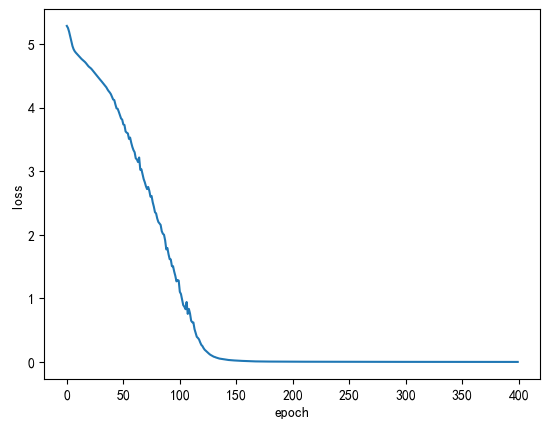

In [11]:
import matplotlib.pyplot as plt
from TranslationDataset import TranslationDataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split


def save_checkpoint(epoch, model, optimizer, scheduler, loss, path):
    checkpoint = {
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "scheduler_state": scheduler.state_dict(),
        "scheduler_type": type(scheduler).__name__,
        "loss": loss,
    }
    torch.save(checkpoint, path)


def load_checkpoint(model, optimizer, scheduler, path):
    if path is not None:
        checkpoint = torch.load(path)
        if model:
            model.load_state_dict(checkpoint["model_state_dict"])
        if optimizer:
            optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
            print(f"从{checkpoint['epoch']}开始训练")
        if scheduler:
            scheduler.load_state_dict(checkpoint["scheduler_state"])
        return checkpoint["epoch"], checkpoint["loss"]

    print("未发现检查点")
    return 0, float("inf")


dataset = TranslationDataset(
    file_path="../data/translate/TranslationData.csv",
    max_lines=10,  # 读取10行
)

train_dataset, test_dataset = random_split(dataset, [0.9, 0.1])  # 百分之九十作为训练集

device = "cuda" if torch.cuda.is_available() else "cpu"
src_vocab_size = len(dataset.ch_token_to_index)
tgt_vocab_size = len(dataset.en_token_to_index)
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=64,
    num_layers=6,
    heads=4,
    dropout=0,  # 这里我们因为是过拟合，所以dropout设置为0
).to(
    device
)  # 如果你要拟合大数据集,d_moel,num_layers,heads,dropout需要做出相应的调整

epochs = 400
lr = 1.0  # 因为使用学习率调度器，因此我们初始学习率可以比较大
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=lr,
    betas=(0.9, 0.98),
    eps=1e-9,  # weight_decay=1e-4 # 同样,为了过拟合不使用权重衰减
)
padding_idx = dataset.en_token_to_index[
    "<pad>"
]  # 忽略填充字符的损失计算,因为它没有实际意义
loss_fn = nn.CrossEntropyLoss(ignore_index=padding_idx)
batch_size = 10

train_loader, test_loader = DataLoader(
    train_dataset, batch_size=batch_size
), DataLoader(test_dataset, batch_size=batch_size)

total_steps = int(epochs * (len(dataset) / batch_size))
warmup_steps = int(total_steps * 0.4)  # 我们设置预热步骤为总步数的百分之40
print(f"total_steps: {total_steps},warmup_steps: {warmup_steps}")
scheduler = torch.optim.lr_scheduler.LambdaLR(
    optimizer=optimizer,
    lr_lambda=lambda step: (
        512 ** (-0.5)  # 模型维度的平方根倒数
        * min(
            (step + 1) ** (-0.5),  # 衰减阶段：步长的平方根倒数
            (step + 1) * (warmup_steps ** (-1.5)),  # 预热阶段：线性增长
        )
    ),
)


def evaluate(model, test_loader, device):
    model.eval().to(device)
    with torch.no_grad():
        total_val_loss = 0
        for src, tgt in test_loader:
            tgt_input = tgt[:, :-1]  # (batch_size, seq_len-1)
            # 预测目标去掉第一个<bos>
            tgt_target = tgt[:, 1:]  # (batch_size, seq_len-1)

            src_key_padding_mask = (src == dataset.ch_token_to_index["<pad>"]).to(
                device
            )
            tgt_key_padding_mask = (tgt_input == dataset.en_token_to_index["<pad>"]).to(
                device
            )

            src, tgt_input, tgt_target = (
                src.to(device),
                tgt_input.to(device),
                tgt_target.to(device),
            )
            pred = model(src, tgt_input, src_key_padding_mask, tgt_key_padding_mask)

            loss = loss_fn(pred.reshape(-1, tgt_vocab_size), tgt_target.reshape(-1))
            total_val_loss += loss.item()
    return total_val_loss / len(test_loader)


error = []
path = None  # 如果你有保存好的检查点，在这里填充具体的文件路径
start_epoch = 0

# start_epoch, loss = load_checkpoint(model, optimizer, scheduler, path) # 如果你有保存好的模型，那么取消这一行的注释
for epoch in range(start_epoch, epochs):
    model.train()  # 开启训练模式
    total_loss = 0
    best_val_loss = 1e10  # 设置初始最佳loss
    for src, tgt in train_loader:
        # 解码器输入取tgt的前n-1个token（去掉最后一个<eos>或<pad>）
        tgt_input = tgt[:, :-1]  # 形状：(batch_size, seq_len-1)
        # 预测目标取tgt的后n-1个token（去掉第一个<bos>）
        tgt_target = tgt[:, 1:]  # 形状：(batch_size, seq_len-1)

        # 生成掩码（基于tgt_input的长度）
        src_key_padding_mask = (src == dataset.ch_token_to_index["<pad>"]).to(device)
        tgt_key_padding_mask = (tgt_input == dataset.en_token_to_index["<pad>"]).to(
            device
        )

        # 移到设备
        src, tgt_input, tgt_target = (
            src.to(device),
            tgt_input.to(device),
            tgt_target.to(device),
        )

        # 模型前向传播（用tgt_input而非完整tgt）
        pred = model(src, tgt_input, src_key_padding_mask, tgt_key_padding_mask)

        # 计算损失（pred的形状是(batch, seq_len-1, tgt_vocab_size)，与tgt_target对齐）
        loss = loss_fn(pred.reshape(-1, tgt_vocab_size), tgt_target.reshape(-1))

        # 参数更新
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(
            model.parameters(), max_norm=5.0
        )  # 设置5为最大梯度
        optimizer.step()
        scheduler.step()
        total_loss += loss.item()
    val_loss = evaluate(model, test_loader, device)  # 训练集上评估
    if val_loss < best_val_loss:
        torch.save(model.state_dict(), "best_model.pth")  # 保存最佳模型
    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(train_loader)
        print(
            f"epoch {epoch + 1}, loss: {avg_loss:.6f}, perplexity: {torch.exp(torch.tensor(avg_loss)).item():.6f},val_loss: {val_loss}"
        )
    # 如果你需要保存检查点，取消下面的注释并更改path_to_save为具体的文件路径
    # if (epoch + 1) % 50 == 0: #
    #     save_checkpoint(epoch + 1, model, optimizer, scheduler, loss, path)
    #     path_to_save = None
    #     print(f"已保存为{path_to_save}")
    error.append(loss.item())
plt.plot(error)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

# 预测

In [12]:
def preprocess_chinese(sentence, ch_token_to_index):
    # 分词
    tokens = sentence.split()
    # 转换为索引，未知词用<unk>
    index_tokens = [
        ch_token_to_index.get(token, ch_token_to_index["<unk>"]) for token in tokens
    ]
    # 添加首尾标记
    index_tokens = (
        [ch_token_to_index["<bos>"]] + index_tokens + [ch_token_to_index["<eos>"]]
    )
   
    # 增加batch维度
    return torch.tensor(index_tokens, dtype=torch.long).unsqueeze(0)


def translate(chinese_sentence, model, dataset, device):
    model.eval().to(device)
    ch_token_to_index = dataset.ch_token_to_index
    en_token_to_index = dataset.en_token_to_index
    en_index_to_token = dataset.en_index_to_token

    # 预处理中文输入
    src_tensor = preprocess_chinese(
        chinese_sentence,
        ch_token_to_index, 
    ).to(device)
    src_key_padding_mask = (src_tensor == ch_token_to_index["<pad>"]).to(device)

    # 获取编码器输出（只需计算一次）
    # 如果我们直接调用model.forward方法，那么自回归生成中每一次都要计算一次解码器输出，因此我们在预测函数中每个层我们单独使用
    with torch.no_grad():
        src_embedded = model.encoder_embedding_position(src_tensor)
        encoder_out = src_embedded
        for encode_layer in model.encoders:
            encoder_out = encode_layer(encoder_out, src_key_padding_mask)

    # 自回归生成英文翻译
    tgt_tokens = [en_token_to_index["<bos>"]]  # 从起始标记开始
    tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)

    for _ in range(dataset.en_max_length - 1):  # 限制最大长度
        # 目标序列的填充掩码
        tgt_key_padding_mask = (tgt_tensor == en_token_to_index["<pad>"]).to(device)

        # 解码器前向传播
        with torch.no_grad():
            tgt_embedded = model.decoder_embedding_position(tgt_tensor)
            decoder_out = tgt_embedded
            for decoder_layer in model.decoders:
                decoder_out = decoder_layer(
                    encoder_out, decoder_out, src_key_padding_mask, tgt_key_padding_mask
                )
            # 预测下一个token
            pred_logits = model.final_linear(decoder_out)  # (1, seq_len, vocab_size)
            next_token_idx = torch.argmax(pred_logits[:, -1, :], dim=-1).item()

        # 添加到结果并更新输入
        tgt_tokens.append(next_token_idx)
        tgt_tensor = torch.tensor(tgt_tokens, dtype=torch.long).unsqueeze(0).to(device)

        # 停止
        if next_token_idx == en_token_to_index["<eos>"]:
            break

    # 转换为英文句子
    return (
        " ".join([en_index_to_token[idx] for idx in tgt_tokens])
        .strip("<bos>")
        .strip("<eos>")
    )


chinese_input = "大会 1992 年 12 月 22 日 第 47 / 180 号 决议 决定 召开 联合国 人类 住 区 会议 ( 生境 二 ) ， 由 尽可能 高级 别的 代表 参与 。 "
translated_result = translate(chinese_input, model, dataset, device)
print("中文输入:", chinese_input)
print("英文翻译:", translated_result)

中文输入: 大会 1992 年 12 月 22 日 第 47 / 180 号 决议 决定 召开 联合国 人类 住 区 会议 ( 生境 二 ) ， 由 尽可能 高级 别的 代表 参与 。 
英文翻译:  in resolution 47 / 180 of 22 December 1992 , the General Assembly decided to convene the United Nations Conference on Human Settlements at the highest possible level of participation . 


# 模型泛化

过拟合测试完成后，我们可以正式开始模型的训练<br>


In [ ]:
dataset = TranslationDataset(
    file_path="../data/translate/2m_WMT21.csv",
    max_lines=1500000,# 大样本
)
device = "cuda" if torch.cuda.is_available() else "cpu"
src_vocab_size = len(dataset.ch_token_to_index)
tgt_vocab_size = len(dataset.en_token_to_index)
model = Transformer(
    src_vocab_size=src_vocab_size,
    tgt_vocab_size=tgt_vocab_size,
    d_model=512,
    num_layers=6,
    heads=8,
    dropout=0.3,
)
# 训练步骤不变,训练10-15个epoch即可
# 训练步骤....

In [ ]:
# 若加载训练好的检查点，取消注释
# model.load_state_dict(torch.load("model_epoch_1.pth")["model_state_dict"])
# chinese_input = "今 天 我 很 开心 。"
# translate(chinese_input, model, dataset, "cuda")